In [2]:
from imgaug import augmenters as iaa
import numpy as np
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import torchvision.transforms.functional as TF
import os
from torchvision import datasets, transforms
from torch.optim import Adam

from pytorch_lightning import Trainer, seed_everything

import utils as utils

DATA_DIR = './fashionMNIST/'

In [3]:
class CustomAugmentor:
    
    def __init__(self):
            self.aug = iaa.Sequential([iaa.flip.Fliplr(p=0.5),
                            iaa.flip.Flipud(p=0.5),
                            iaa.GaussianBlur(sigma=(0.0, 0.1)),
                           ])
    
    def __call__(self, img):
        img = np.array(img)
        # Return a copy here to work around the error: ValueError: At least one stride 
        # in the given numpy array is negative, and tensors with negative strides 
        # are not currently supported.
        return self.aug.augment_image(img).copy()


In [4]:
class LitMNIST(LightningModule):

    def __init__(self):
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = torch.nn.Conv2d(1, 32, 3)
        self.layer_2 = torch.nn.MaxPool2d(2)
        self.layer_3 = torch.nn.Conv2d(32, 64, 3)
        self.layer_4 = torch.nn.MaxPool2d(2)
        self.layer_5 = torch.nn.Conv2d(64, 64, 3)
        self.fc1 = torch.nn.Linear(64 * 3 * 3, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        

    def forward(self, x):
        batch_size, channels, width, height = x.size()
        
        # (b, 1, 28, 28) -> (b, 1*28*28)
        # x = x.view(batch_size, -1)
        
        # conv + relu
        x = self.layer_1(x)
        x = torch.relu(x)
        
        # maxpool
        x = self.layer_2(x)
        
        # conv + relu
        x = self.layer_3(x)
        x = torch.relu(x)
        
        # maxpool
        x = self.layer_4(x)
        
        # conv + relu
        x = self.layer_5(x)
        x = torch.relu(x)

        # flatten
        x = torch.flatten(x, start_dim=1)
        
        # densely connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        
        x = self.fc2(x)
        
        # probability distribution over labels
        x = torch.log_softmax(x, dim=1)

        return x
    
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def prepare_data(self):
        # transforms for images
        transform=transforms.Compose([CustomAugmentor(),
                                      transforms.ToTensor()])
        fmnist_train = FashionMNIST(DATA_DIR, train=True, download=True, transform=transform)
        self.fmnist_test = FashionMNIST(DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
        
        self.fmnist_train, self.fmnist_val = random_split(fmnist_train, [55000, 5000])
        
    def train_dataloader(self):
        return DataLoader(self.fmnist_train, batch_size=64, num_workers=utils.get_num_cpus())

    def val_dataloader(self):
        return DataLoader(self.fmnist_val, batch_size=64, num_workers=utils.get_num_cpus())

    def test_dataloader(self):
        return DataLoader(self.fmnist_test, batch_size=64, num_workers=utils.get_num_cpus())

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.cross_entropy_loss(logits, y)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.cross_entropy_loss(logits, y)
        
        return {'test_loss': loss}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': tensorboard_logs}

In [5]:
net = LitMNIST()
x = torch.Tensor(1, 1, 28, 28)
out = net(x)

In [6]:
out

tensor([[-5.3297e+33, -2.8257e+33, -5.1759e+33, -6.0839e+33, -6.2677e+33,
         -3.5354e+33, -3.8241e+33, -5.9980e+33, -3.3619e+33,  0.0000e+00]],
       grad_fn=<LogSoftmaxBackward>)

In [7]:
net.prepare_data()

In [8]:
# Class map from the fashion mnist website https://github.com/zalandoresearch/fashion-mnist
classes = {0: 'T-shirt/top',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle Boot'}

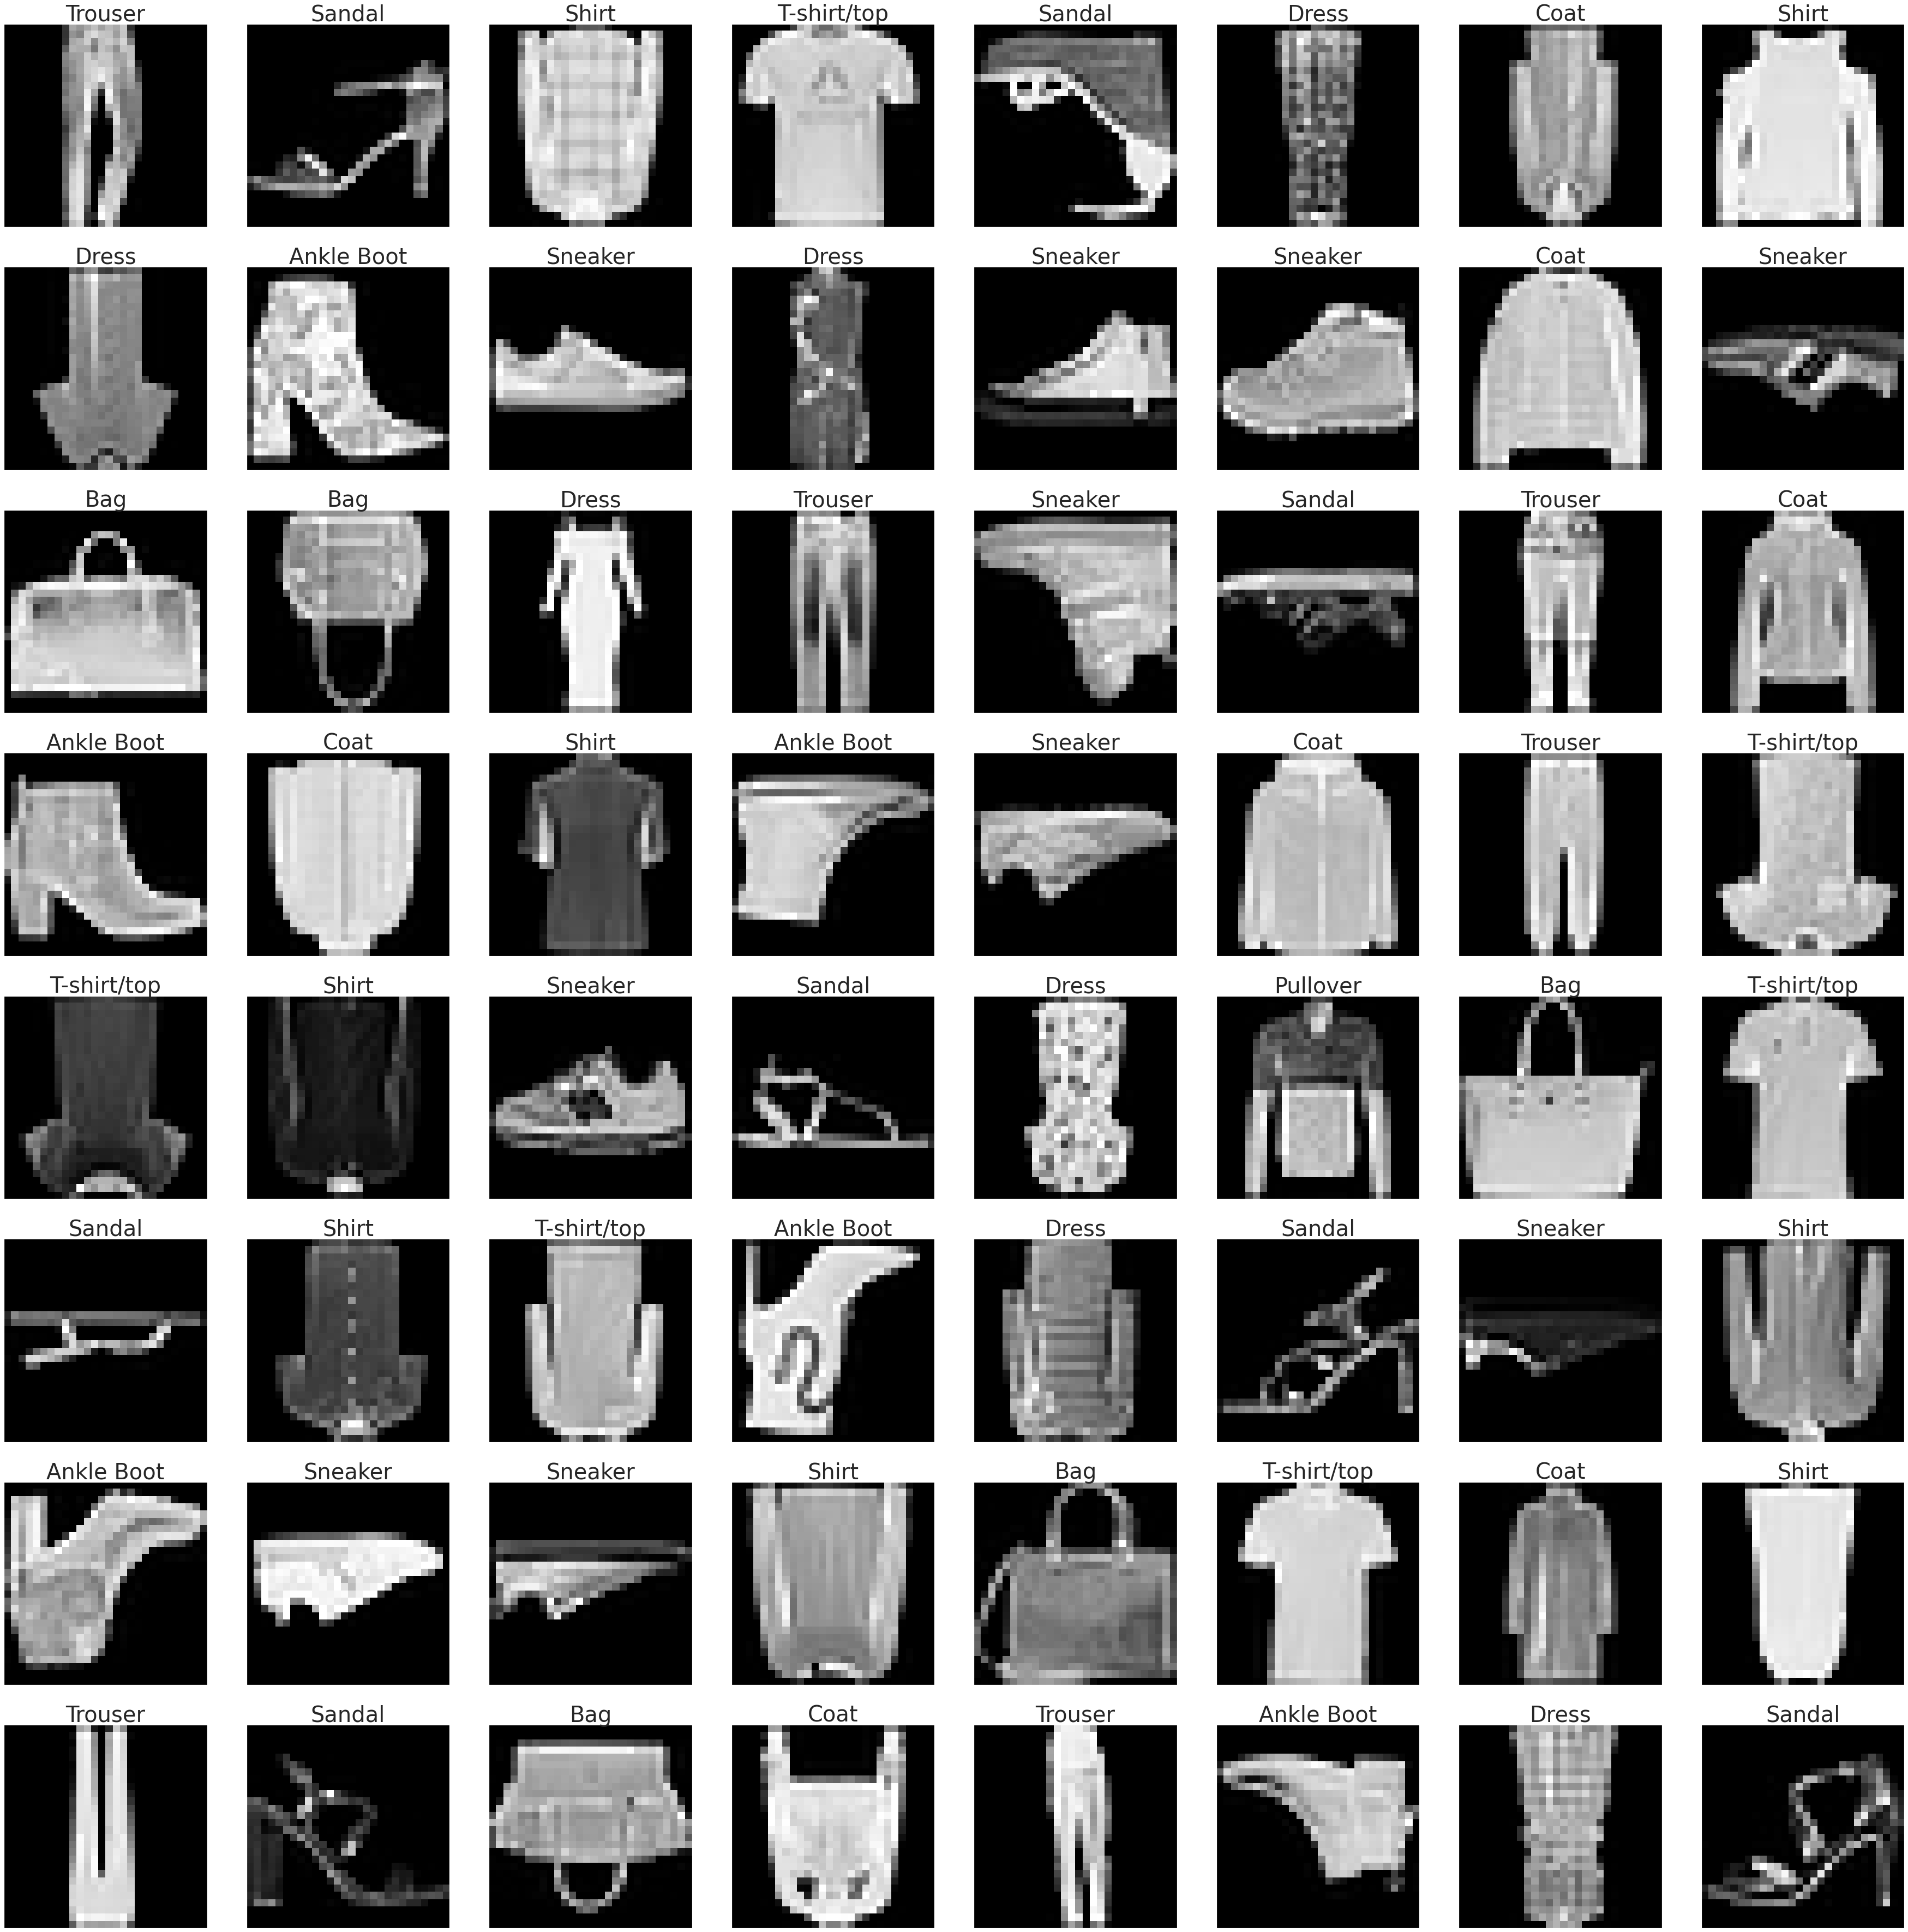

In [9]:
dl = net.train_dataloader()
utils.display_grid_data(dl, classes, ncols=8)

In [10]:
# Setup lightning for reproducability between runs.  That way we can
# make tweaks and see what the effect on performance is.  If we don't set this we will
# get different accuracy results between runs, and will complicate measuring the effect
# of our changes on the performance.  We also have to setup the trainer for deterministic
# runs as well (below)

seed_val = 42
seed_everything(seed_val)

42

In [11]:
model = LitMNIST()
# Set the trainer for deterministic runs.
trainer = Trainer(max_epochs=3, deterministic=True)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type      | Params
--------------------------------------
0 | layer_1 | Conv2d    | 320   
1 | layer_2 | MaxPool2d | 0     
2 | layer_3 | Conv2d    | 18 K  
3 | layer_4 | MaxPool2d | 0     
4 | layer_5 | Conv2d    | 36 K  
5 | fc1     | Linear    | 36 K  
6 | fc2     | Linear    | 650   


1

In [12]:
trainer.test()

--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(0.4053)}
--------------------------------------------------------------------------------



{'test_loss': 0.40532687306404114}

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./lightning_logs')
writer.add_graph(model, torch.Tensor(1, 1, 28, 28))
writer.close()

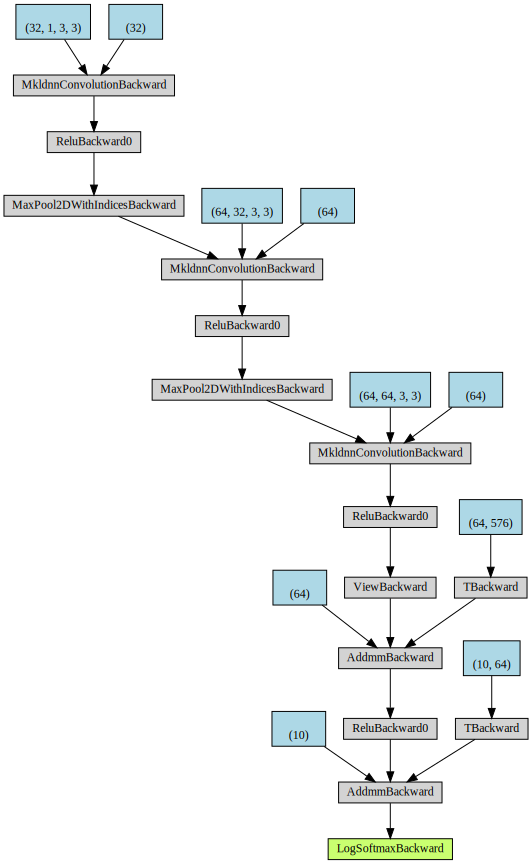

In [14]:
from torchviz import make_dot
out = model(torch.Tensor(1, 1, 28, 28))
make_dot(out)  

In [15]:
print(model)

LitMNIST(
  (layer_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (layer_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (layer_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [16]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 2.6809e-01,  3.0347e-01, -5.9610e-02],
          [ 2.9879e-01, -6.8305e-02,  7.4336e-02],
          [-1.7607e-01,  2.2047e-01,  3.3152e-01]]],


        [[[-2.5873e-01,  3.2117e-01,  8.1650e-02],
          [ 2.4822e-01,  3.3193e-02,  1.5815e-01],
          [-3.4110e-02,  2.8496e-01,  6.7391e-02]]],


        [[[-4.5659e-02,  2.0971e-01, -4.7555e-02],
          [-3.0614e-01, -2.2953e-01,  2.6673e-01],
          [-9.5421e-01, -2.6766e-01, -2.8110e-02]]],


        [[[-1.9501e-01, -7.6229e-03, -3.6096e-01],
          [ 3.5253e-01, -2.9274e-01,  3.1469e-01],
          [ 1.3166e-01, -7.5139e-02,  2.9113e-01]]],


        [[[ 4.7162e-02,  2.7548e-01,  4.8264e-02],
          [-1.0222e-01,  1.1189e-01, -4.8710e-02],
          [ 1.1792e-01,  3.1049e-01,  2.1983e-01]]],


        [[[-6.1112e-02,  3.0056e-01,  1.7474e-01],
          [ 2.6494e-01, -1.5183e-01, -3.3691e-01],
          [ 2.3342e-02, -2.1017e-01,  3.9816e-01]]],


        [[[ 1.0116e-01,  1.7698e-01,

In [17]:
[module for module in model.modules() if type(module) != nn.Sequential]

[LitMNIST(
   (layer_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
   (layer_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (layer_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
   (layer_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (layer_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
   (fc1): Linear(in_features=576, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=10, bias=True)
 ),
 Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
 Linear(in_features=576, out_features=64, bias=True),
 Linear(in_features=64, out_features=10, bias=True)]

In [18]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 27150), started 7 days, 0:22:18 ago. (Use '!kill 27150' to kill it.)

In [19]:
dl = model.test_dataloader()

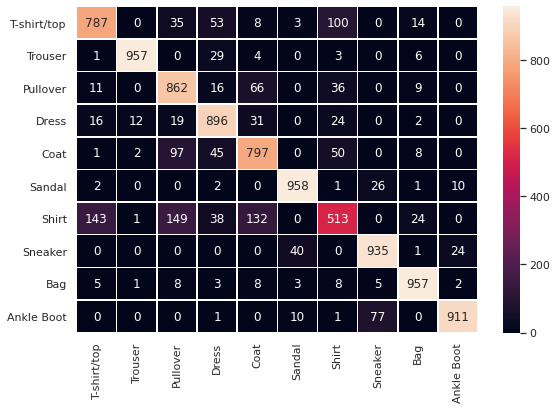

In [20]:
labels, predictions = utils.model_predictions(dl, model)
df, acc = utils.measure_accuracy(labels, predictions, classes)

In [21]:
df

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle Boot
T-shirt/top,787,0,35,53,8,3,100,0,14,0
Trouser,1,957,0,29,4,0,3,0,6,0
Pullover,11,0,862,16,66,0,36,0,9,0
Dress,16,12,19,896,31,0,24,0,2,0
Coat,1,2,97,45,797,0,50,0,8,0
Sandal,2,0,0,2,0,958,1,26,1,10
Shirt,143,1,149,38,132,0,513,0,24,0
Sneaker,0,0,0,0,0,40,0,935,1,24
Bag,5,1,8,3,8,3,8,5,957,2
Ankle Boot,0,0,0,1,0,10,1,77,0,911


In [22]:
acc

0.8573